![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/master/jupyter/Cards/SparkOcrImageToTextPrinted_V2.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

In [1]:
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

Saving spark-license-v422.json to spark-license-v422.json


In [2]:
!pip install transformers

# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.4/448.4 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 KB 20.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.johnsnowlabs.com/4.2.4-f9a344ae3ee87461f69ebabea37d12f7c19ca584
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.2/30.2 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import pkg_resources

from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

In [3]:
# Start spark
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)

Spark version: 3.2.1
Spark NLP version: 4.2.4
Spark OCR version: 4.2.4



# Read image and display it


    Image #0:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


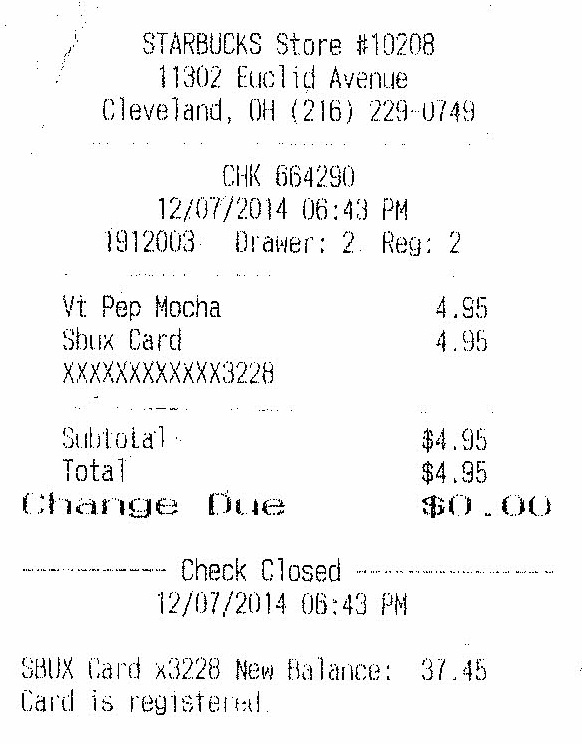

In [19]:
imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR).transform(image_df), "image")

# Define OCR Pipeline for detect and recognize text 

In [20]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(True) \
    .setSizeThreshold(-1) \
    .setLinkThreshold(0.3) \
    .setWidth(500)

ocr = ImageToTextV2.pretrained("ocr_base_printed_v2", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setGroupImages(True) \
    .setOutputCol("text") \
    .setRegionsColumn("text_regions")

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green) \
    .setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    ocr,
    draw_regions
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB


# Run pipeline and show results


    Image #0:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


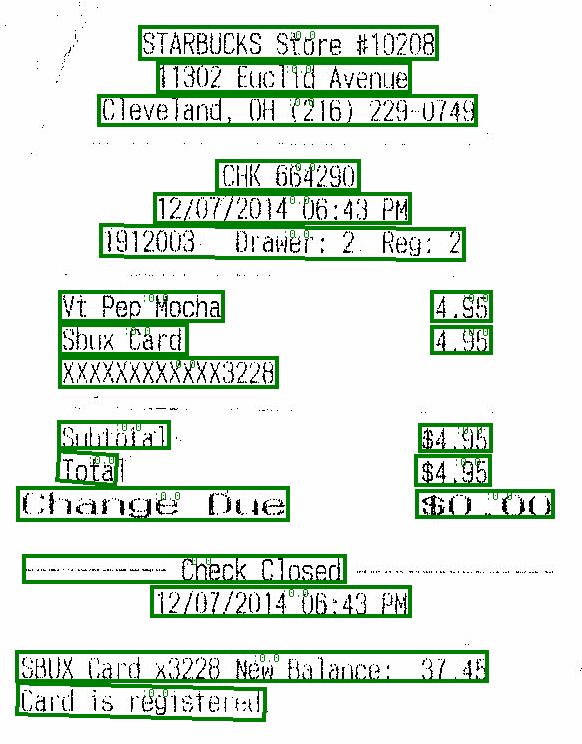

STARBUCKS STORE #10208
11302 EUCLID AVENUE
CLEVELAND, OH (216) 229-0749
CHK 664290
12/07/2014 06:43 PM
1912003- DRAWER: 2. REG: 2
VT PEP MOCHA
SBUX CARD : 4.95
XXXXXXXXXXXX3228
SUBTOTAL: $4.95
TOTAL @ 6 @ < $4.95
CHANGE DUE $0.00
................ CCHECK CLOSED
12/07/2014 06:43 PM
SBUX CARD X3228 NEW BALANCE: 37.45
CARD IS REGISTERED


In [21]:
result = pipeline.transform(image_df).cache()
display_images(result, "image_with_regions")
print(("").join([x.text for x in result.select("text").collect()]))